In [1]:
OUTDATED_IGNORE=1

import pandas as pd 
import numpy as np 
from sklearn.svm import NuSVR, NuSVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold, train_test_split, GridSearchCV, ParameterSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
import pingouin as pg
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import random
import pwlf
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, mean_absolute_error, recall_score, r2_score
import os
import statsmodels.api as sm

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
with open(r"../../DerivedData/cohorts_subjects_list.pickle", "rb") as input_file:
        cohorts = pickle.load(input_file)
        
# in the end outcomes are the scores, however here I am setting up the baselines predicting prematurity status etc
outcomes = ['Cognitive Score','Language Score','Motor Score']
n_folds = 46 # to recreate train/test proportions 
it_num = 1000 # for null distributions



In [248]:
### ages
df = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)

### global FA
glob = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)

metrics = ['FA', 'L1', 'RD', 'MD']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in glob.iterrows():
        glob.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])
df = pd.merge(df, glob[['subject_id', 'FA']], on=['subject_id'])  

### median FA regions 
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

#new_df = df.copy()
df = pd.merge(df, diff[FA_cols], on=['subject_id'])

df = df[df.subject_id.isin(cohorts['D'])]

### ADD MOTION VALUES HERE FOR THE CORRECTION!!! 
qc = pd.read_csv('../../SourceData/release3_subject_info.tsv', sep='\t')
for i, row in df.iterrows():
    
    trans = qc[(qc['participant_id '] == row.subject_id + ' ') & (qc['session_id '] == row.session_id)]['qc_dmri_shard_translation '].values[0]
    rot = qc[(qc['participant_id '] == row.subject_id + ' ') & (qc['session_id '] == row.session_id)]['qc_dmri_shard_rotation '].values[0]
    #snr = qc[(qc['participant_id '] == row.subject_id + ' ') & (qc['session_id '] == row.session_id)]['qc_dmri_shard_snr '].values[0]
    #outlier = qc[(qc['participant_id '] == row.subject_id + ' ') & (qc['session_id '] == row.session_id)]['qc_dmri_shard_outlier_ratio '].values[0]
    
    df.loc[i, 'qc_translation'] = trans
    df.loc[i, 'qc_rotation'] = rot
    #df.loc[i, 'qc_dmri_shard_snr'] = snr
    #df.loc[i, 'qc_dmri_shard_outlier_ratio'] = outlier

In [296]:
def evaluate(y_true, y_pred):
    
    return pg.corr(y_true, y_pred)['r'][0], mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)


def preprocess(X_train, X_val, cols, inflection=36, correct_motion=False):
    ## inpute
    X_train, X_val = _inpute_median(X_train=X_train, X_val=X_val, cols=train_cols)
    
    if correct_motion == True:
        X_train, X_val = _correct_motion(X_train=X_train, X_val=X_val, cols=train_cols)
    ## correct PMA
    X_train, X_val = _correct_PMA_scan(X_train=X_train, X_val=X_val, cols=train_cols, inflection=36)
    ## scale
    X_train, X_val = _scaling(X_train=X_train, X_val=X_val, cols=train_cols)
    
    return X_train, X_val

def _inpute_median(X_train, X_val, cols):
    for col in cols:
        md = np.nanmedian(X_train[col])
        
        X_train[col].fillna(md, inplace= True)
        X_val[col].fillna(md, inplace= True)
   
    return X_train, X_val

def _correct_PMA_scan(X_train, X_val, cols, inflection = 36):
    
    x0 = np.array([min(X_train.PMA_scan.values), inflection, max(X_train.PMA_scan.values)])
    
    for col in cols:
        
        myPWLF = pwlf.PiecewiseLinFit(X_train.PMA_scan.values, X_train[col].values)
        myPWLF.fit_with_breaks(x0)
        
        ## correct train 
        yHat_train = myPWLF.predict(X_train.PMA_scan.values)
        res_train = X_train[col].values - yHat_train
        
        ## correct test 
        yHat_test = myPWLF.predict(X_val.PMA_scan.values)
        res_test = X_test[col].values - yHat_test
        
        X_train[col] = res_train
        X_val[col] = res_test
    return X_train, X_val   

def _scaling(X_train, X_val, cols):
    
    scaler = MinMaxScaler()
    scaler.fit(X_train[cols].values)
    
    X_train[cols] = scaler.transform(X_train[cols].values)
    X_val[cols] = scaler.transform(X_val[cols].values)
    
    return X_train, X_val

def _correct_motion(X_train, X_val, cols):
    
    for col in cols:
        
        model = sm.OLS(X_train[col].values, X_train[['qc_translation', 'qc_rotation']].values).fit()
        
        yHat_train = model.predict(X_train[['qc_translation', 'qc_rotation']].values) 
        res_train = X_train[col].values - yHat_train
        #print(yHat_train)
    
    
        yHat_test = model.predict(X_val[['qc_translation', 'qc_rotation']].values) 
        res_test = X_val[col].values - yHat_test
        
        X_train[col] = res_train
        X_val[col] = res_test
    return X_train, X_val   


#  SETTING UP SPLITTING 


In [135]:
df = df[df.subject_id.isin(cohorts['D'])]

param_grid = {
    
    'nu' : np.linspace(0.1,1,10),
    'C' : [0.01,0.1,1,5,9,10],
    'kernel' : ['linear'],
    'shrinking' : [True, False]
             }

outcome = 'Cognitive Score'

In [136]:
## hyperparameters
param_list = list(ParameterSampler(param_grid, n_iter=20, random_state=42))
for d in param_list:
    d['nu'] = np.round(d['nu'], 1)

In [195]:
## outer fold - N times train_test_spilit
N = 1
train_cols = FA_cols[:-1]
inputs = 'ROIs age corrected'
outer_res = []


### ROIS
for n in range(N):
    
    df_train, df_test = train_test_split( df,  test_size=n_folds, random_state=n)
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)

    ### inner loop
    inner_res = []
    cv_inner = LeaveOneOut()
    for i,  rep in enumerate(param_list[:2]):    
        y_hat = []
        y_true = []

        for train_index, test_index in loo.split(df_train):
        
            X_train, X_val = df_train.loc[train_index], df_train.loc[test_index]
            #preprocess 
            X_train, X_val = preprocess(X_train=X_train, X_val=X_val, cols=train_cols, inflection=36)
    
            #
            model = NuSVR(**rep)
            model.fit(X_train[train_cols].values, X_train[outcome].values)
            y_out = model.predict(X_val[train_cols].values)
        
            y_hat.append(y_out[0])
            y_true.append(X_val[outcome].values[0])
        
        rho, mae, r2 = evaluate(y_true=y_true, y_pred=y_hat)
    
        inner_res.append([i, rho, mae, r2])
        print('{}th Inner Loop FINISHED'.format(i))
        print(rho, mae, r2)
        
        
    inner_res = pd.DataFrame(data=inner_res, columns=['params', 'rho', 'mae', 'r2'])
    opt_params = param_list[inner_res[inner_res['mae'] == inner_res['mae'].min()]['params'].values[0]]   

    ## outer loop 
    ## preprocess 
    df_train, df_test = preprocess(X_train=df_train, X_val=df_test, cols=train_cols, inflection=36)

    fmodel = NuSVR(**opt_params)
    fmodel.fit(df_train[train_cols].values, df_train[outcome].values)
    f_yhat = fmodel.predict(df_test[train_cols].values).round(0)
    rho, mae, r2 = evaluate(y_true=df_test[outcome].values, y_pred=f_yhat)
    outer_res.append([outcome,inputs, opt_params,rho, mae, r2, np.array(df_train[outcome].values),np.array(f_yhat)])
    
    print('\n***')
    print('{}th Outer Loop FINISHED'.format(n))
    print(rho, mae, r2)
    print('\n***')
    
outer_res = pd.DataFrame(data=outer_res, columns=['outcome','inputs', 'params', 'rho', 'mae', 'r2', 'y_true', 'y_pred'])    

0th Inner Loop FINISHED
-0.054036733017058525 6.333033032049872 -0.12226513772597092
1th Inner Loop FINISHED
-0.18718406286085457 6.490565914431308 -0.17589110331350044

***
0th Outer Loop FINISHED
-0.0074928088252248365 5.173913043478261 -0.0635586811857225

***


In [205]:
outer_res['y_true'][0] * 2

array([188., 206., 152., 214., 194., 188., 214., 188., 152., 200., 158.,
       214., 200., 194., 214., 170., 194., 194., 200., 206., 200., 194.,
       152., 200., 188., 170., 214., 188., 176., 200., 194., 206., 194.,
       200., 206., 182., 214., 206., 194., 188., 200., 206., 206., 194.,
       214., 214., 194., 188., 194., 206., 214., 200., 214., 194., 206.,
       194., 194., 200., 206., 158., 200., 206., 214., 194., 182., 194.,
       194., 182., 200., 152., 214., 182., 194., 170., 194., 214., 170.,
       188., 146., 206.])

In [ ]:
#outer_res.to_csv('../../Results/predictions/nested_validation.csv')

In [132]:
def evaluate(y_true, y_pred):
    
    return pg.corr(y_true, y_pred)['r'][0], mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)


def preprocess(X_train, X_val, cols, inflection=36):
    ## inpute
    X_train, X_val = _inpute_median(X_train=X_train, X_val=X_val, cols=train_cols)
    ## correct 
    X_train, X_val = _correct_PMA_scan(X_train=X_train, X_val=X_val, cols=train_cols, inflection=36)
    ## scale
    X_train, X_val = _scaling(X_train=X_train, X_val=X_val, cols=train_cols)
    
    return X_train, X_val

def _inpute_median(X_train, X_val, cols):
    for col in cols:
        md = np.nanmedian(X_train[col])
        
        X_train[col].fillna(md, inplace= True)
        X_val[col].fillna(md, inplace= True)
   
    return X_train, X_val

def _correct_PMA_scan(X_train, X_val, cols, inflection = 36):
    
    x0 = np.array([min(X_train.PMA_scan.values), inflection, max(X_train.PMA_scan.values)])
    
    for col in cols:
        
        myPWLF = pwlf.PiecewiseLinFit(X_train.PMA_scan.values, X_train[col].values)
        myPWLF.fit_with_breaks(x0)
        
        ## correct train 
        yHat_train = myPWLF.predict(X_train.PMA_scan.values)
        res_train = X_train[col].values - yHat_train
        
        ## correct test 
        yHat_test = myPWLF.predict(X_val.PMA_scan.values)
        res_test = X_test[col].values - yHat_test
        
        X_train[col] = res_train
        X_val[col] = res_test
    return X_train, X_val   

def _scaling(X_train, X_val, cols):
    
    scaler = MinMaxScaler()
    scaler.fit(X_train[cols].values)
    
    X_train[cols] = scaler.transform(X_train[cols].values)
    X_val[cols] = scaler.transform(X_val[cols].values)
    
    return X_train, X_val

## Visualising the predictions 

In [26]:
def get_message(results, outcome, inputs, metric):
    
    try: 
        mean = np.nanmean(results[(results.outcome == outcome) & (results.inputs == inputs)][metric].values)
        std = np.nanstd(results[(results.outcome == outcome) & (results.inputs == inputs)][metric].values)
    
        lim = 1.96 * (std/np.sqrt(100))
    except RuntimeWarning: 
        mean, std, lim = 0, 0, 0
    return '{:.3f} [{:.4f};{:.4f}]'.format(mean, mean-lim, mean+lim)

### CONTINUOUS AGE CORRECTED NESTED

In [31]:
results = pd.read_csv('../../Results/predictions/nested_validation_age_corr.csv', index_col=0)
results.loc[results.rho =='undefined', 'rho'] = np.nan
results['rho'] = results['rho'].astype(np.float32)
results['r2'] = results['r2'].astype(np.float32)

for col in ['y_true', 'y_pred']:
    results[col] = results[col].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

names = ['ROIs (52) a.c.', 'Random (128) a.c', 'Random (256) a.c', 'Random (512) a.c', 'Random (1024) a.c']
in_n = ['ROIs age corrected', '128', '256', '512', '1024']
print('Outcome, Inputs, RHO [CI], MAE [CI], R2 [CI]')
for outcome in np.unique(results.outcome.values):
    for name, inputs in zip(names,in_n ): # np.unique(results.inputs.values):
        
        print('{}, {},{},{},{}'.format(
                    outcome, name,
                   get_message(results=results, outcome=outcome, inputs=inputs, metric='rho'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='mae'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='r2'),
                ))

Outcome, Inputs, RHO [CI], MAE [CI], R2 [CI]
Cognitive Score, ROIs (52) a.c.,-0.132 [-0.1547;-0.1094],6.572 [6.4418;6.7017],-0.093 [-0.0995;-0.0865]
Cognitive Score, Random (128) a.c,0.015 [-0.0029;0.0325],6.535 [6.4112;6.6583],-0.074 [-0.0814;-0.0669]
Cognitive Score, Random (256) a.c,0.059 [0.0333;0.0841],6.515 [6.3950;6.6354],-0.071 [-0.0787;-0.0632]
Cognitive Score, Random (512) a.c,0.048 [0.0127;0.0836],6.565 [6.4522;6.6782],-0.078 [-0.0880;-0.0689]
Cognitive Score, Random (1024) a.c,0.075 [0.0494;0.1011],6.526 [6.4085;6.6436],-0.069 [-0.0776;-0.0600]
GA_birth, ROIs (52) a.c.,-0.004 [-0.0381;0.0295],1.586 [1.5456;1.6270],-0.229 [-0.2729;-0.1856]
GA_birth, Random (128) a.c,0.022 [-0.0087;0.0531],1.564 [1.5265;1.6015],-0.250 [-0.3148;-0.1858]
GA_birth, Random (256) a.c,-0.077 [-0.1287;-0.0254],1.716 [1.6770;1.7541],-0.329 [-0.3861;-0.2713]
GA_birth, Random (512) a.c,-0.152 [-0.1988;-0.1056],1.626 [1.5764;1.6757],-0.548 [-0.6382;-0.4571]
GA_birth, Random (1024) a.c,-0.134 [-0.1848;-0

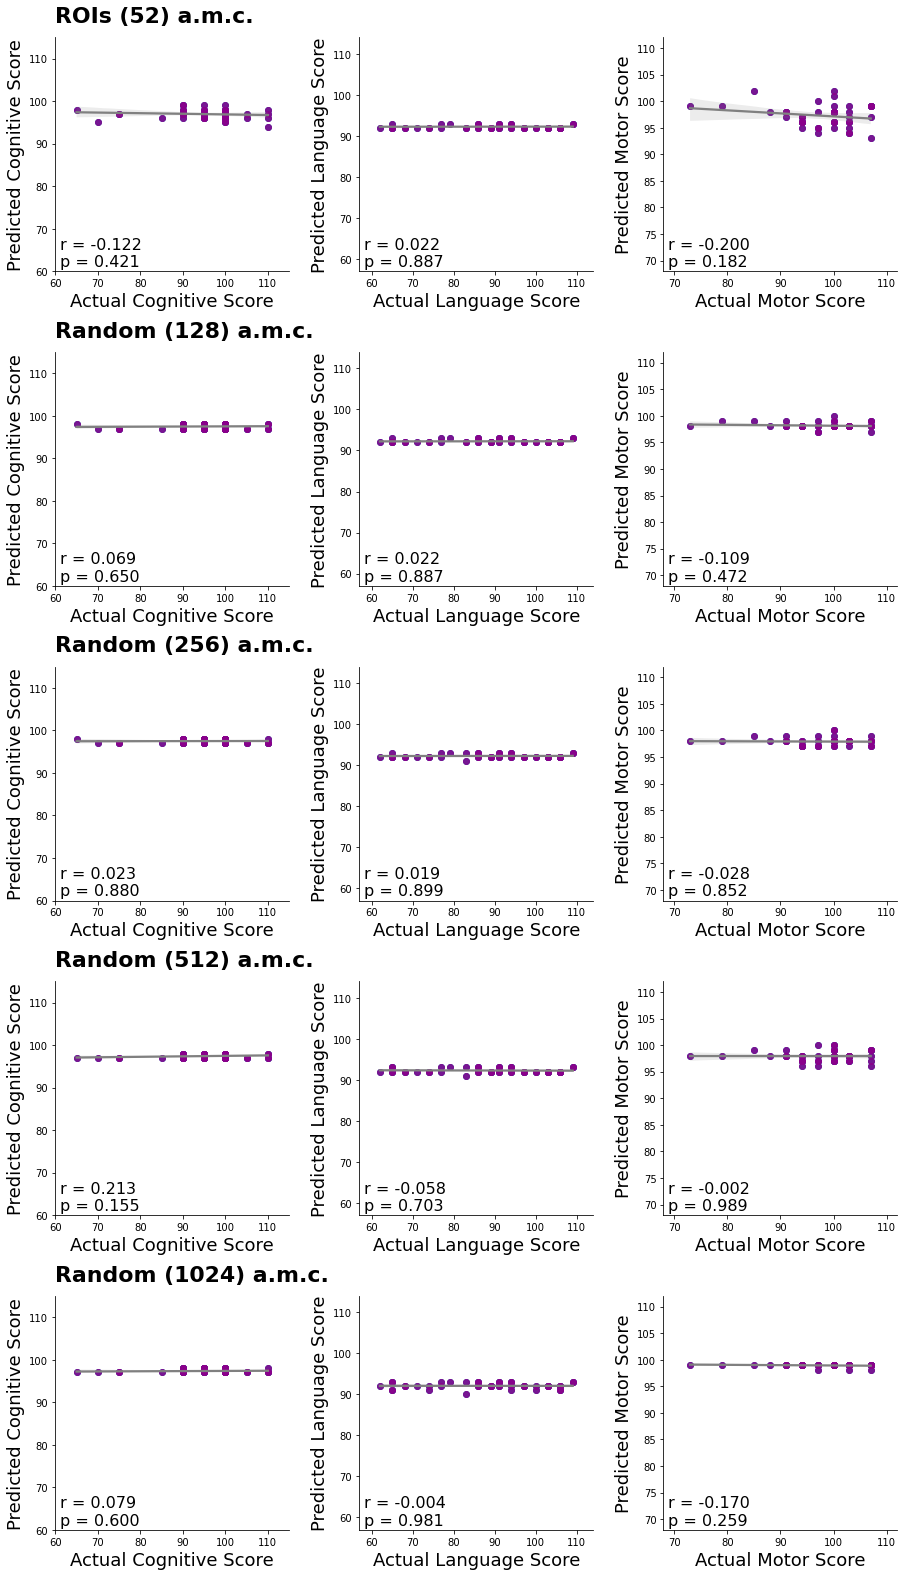

In [37]:
fig, axs = plt.subplots(5,3,sharex=False, sharey=False, figsize=(13,20))

outcomes =['Cognitive Score', 'Language Score', 'Motor Score']

for f,inputs in enumerate(['ROIs age corrected', '128', '256', '512', '1024']):
    
    if inputs == 'ROIs age corrected':
        label = 'ROIs (52) a.m.c.'
    else: 
        label = 'Random ({}) a.m.c.'.format(inputs)
    
    for i,outcome in enumerate(outcomes):
        #print(inputs, outcome)
        x = results[(results.outcome == outcome) & (results.inputs == inputs)]['y_true'].values[0]
        y = results[(results.outcome == outcome) & (results.inputs == inputs)]['y_pred'].values[0]
        
        axs[f,i].scatter(x,y)
    
        axs[f,i].set_xlabel('Actual {}'.format(outcome), fontsize=18)
        axs[f,i].set_ylabel('Predicted {}'.format(outcome), fontsize=18)
    
        axs[f,i].axis('square')
        a = 5
        lower = np.min([np.min(x), np.min(y)]) - a
        upper = np.max([np.max(x), np.max(y)]) + a
    
        axs[f,i].set_ylim(lower, upper)
        axs[f,i].set_xlim(lower, upper)
        #axs[i].axis('square')
    
        ## linear regression 
        test = pg.linear_regression(x, y)
        sns.regplot(x = x, y = y, 
                     ax = axs[f,i], 
               scatter_kws={"color": "darkmagenta"}, line_kws={"color": "gray"})
    
        r, p =  pg.corr(x, y)['r'][0], pg.corr(x, y)['p-val'][0]
        axs[f,i].annotate('r = {:.3f}\np = {:.3f}'.format(r,p),
            xy=(5, 5), xycoords='axes points', fontsize = 16)
    axs[f,0].set_title('{}'.format(label), fontsize=22, loc='left', fontweight='bold', pad=15)

for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
plt.tight_layout(rect=[0, 0, 1, 1.1])
plt.show()

In [ ]:
### CONTINUOUS AGE & motion CORRECTED NESTED

In [38]:
results = pd.read_csv('../../Results/predictions/nested_validation_age_and_motion_corr.csv', index_col=0)
results.loc[results.rho =='undefined', 'rho'] = np.nan
results['rho'] = results['rho'].astype(np.float32)
results['r2'] = results['r2'].astype(np.float32)

for col in ['y_true', 'y_pred']:
    results[col] = results[col].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

names = ['ROIs (52) a.m.c.', 'Random (128) a.m.c', 'Random (256) a.m.c', 'Random (512) a.m.c', 'Random (1024) a.m.c']
in_n = ['ROIs age corrected', '128', '256', '512', '1024']
print('Outcome, Inputs, RHO [CI], MAE [CI], R2 [CI]')
for outcome in np.unique(results.outcome.values):
    for name, inputs in zip(names,in_n ): # np.unique(results.inputs.values):
        
        print('{}, {},{},{},{}'.format(
                    outcome, name,
                   get_message(results=results, outcome=outcome, inputs=inputs, metric='rho'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='mae'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='r2'),
                ))

Outcome, Inputs, RHO [CI], MAE [CI], R2 [CI]
Cognitive Score, ROIs (52) a.m.c.,-0.025 [-0.0369;-0.0132],6.548 [6.4585;6.6372],-0.072 [-0.0803;-0.0643]
Cognitive Score, Random (128) a.m.c,0.102 [0.0807;0.1231],6.539 [6.4476;6.6306],-0.059 [-0.0697;-0.0487]
Cognitive Score, Random (256) a.m.c,0.092 [0.0653;0.1179],6.591 [6.5038;6.6789],-0.069 [-0.0795;-0.0593]
Cognitive Score, Random (512) a.m.c,0.015 [-0.0079;0.0370],6.570 [6.5016;6.6375],-0.070 [-0.0766;-0.0640]
Cognitive Score, Random (1024) a.m.c,0.053 [0.0401;0.0660],6.504 [6.4202;6.5885],-0.052 [-0.0565;-0.0479]
GA_birth, ROIs (52) a.m.c.,-0.102 [-0.1147;-0.0900],1.488 [1.4538;1.5226],-0.051 [-0.0570;-0.0454]
GA_birth, Random (128) a.m.c,-0.031 [-0.0405;-0.0205],1.495 [1.4577;1.5324],-0.047 [-0.0546;-0.0386]
GA_birth, Random (256) a.m.c,0.000 [-0.0544;0.0544],1.435 [1.3884;1.4811],-0.086 [-0.1142;-0.0587]
GA_birth, Random (512) a.m.c,0.041 [0.0089;0.0729],1.389 [1.3476;1.4312],-0.109 [-0.1294;-0.0895]
GA_birth, Random (1024) a.m.c,

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/pingouin/regression.py:432: RuntimeWarning: divide by zero encountered in double_scalars
  r2 = 1 - ss_res / ss_wtot
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


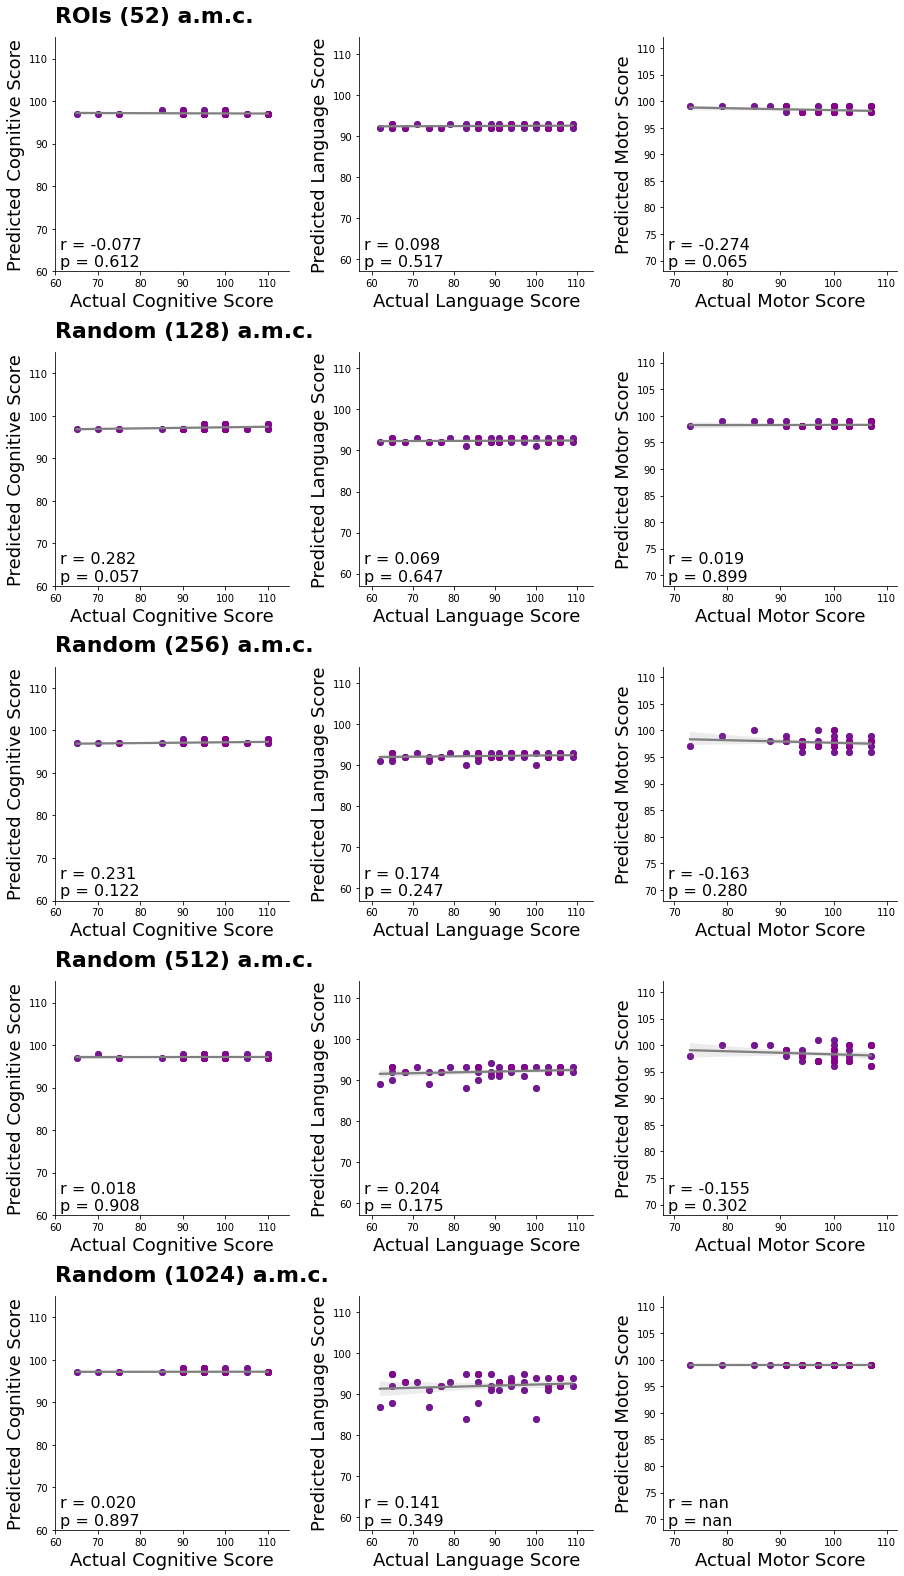

In [39]:
fig, axs = plt.subplots(5,3,sharex=False, sharey=False, figsize=(13,20))

outcomes =['Cognitive Score', 'Language Score', 'Motor Score']

for f,inputs in enumerate(['ROIs age corrected', '128', '256', '512', '1024']):
    
    if inputs == 'ROIs age corrected':
        label = 'ROIs (52) a.m.c.'
    else: 
        label = 'Random ({}) a.m.c.'.format(inputs)
    
    for i,outcome in enumerate(outcomes):
        #print(inputs, outcome)
        x = results[(results.outcome == outcome) & (results.inputs == inputs)]['y_true'].values[0]
        y = results[(results.outcome == outcome) & (results.inputs == inputs)]['y_pred'].values[0]
        
        axs[f,i].scatter(x,y)
    
        axs[f,i].set_xlabel('Actual {}'.format(outcome), fontsize=18)
        axs[f,i].set_ylabel('Predicted {}'.format(outcome), fontsize=18)
    
        axs[f,i].axis('square')
        a = 5
        lower = np.min([np.min(x), np.min(y)]) - a
        upper = np.max([np.max(x), np.max(y)]) + a
    
        axs[f,i].set_ylim(lower, upper)
        axs[f,i].set_xlim(lower, upper)
        #axs[i].axis('square')
    
        ## linear regression 
        test = pg.linear_regression(x, y)
        sns.regplot(x = x, y = y, 
                     ax = axs[f,i], 
               scatter_kws={"color": "darkmagenta"}, line_kws={"color": "gray"})
    
        r, p =  pg.corr(x, y)['r'][0], pg.corr(x, y)['p-val'][0]
        axs[f,i].annotate('r = {:.3f}\np = {:.3f}'.format(r,p),
            xy=(5, 5), xycoords='axes points', fontsize = 16)
    axs[f,0].set_title('{}'.format(label), fontsize=22, loc='left', fontweight='bold', pad=15)

for ax in axs.ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
plt.tight_layout(rect=[0, 0, 1, 1.1])
plt.show()

### categorical with age correction

In [42]:
results = pd.read_csv('../../Results/predictions/nested_validation_categortical_age_corr.csv', index_col=0)
#results.loc[results.rho =='undefined', 'rho'] = np.nan
results['AUC'] = results['AUC'].astype(np.float32)
results['ACC'] = results['ACC'].astype(np.float32)
results['SPEC'] = results['SPEC'].astype(np.float32)
results['SENS'] = results['SENS'].astype(np.float32)

for col in ['y_true', 'y_pred']:
    results[col] = results[col].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

names = ['ROIs (52) a.c.', 'Random (128) a.c', 'Random (256) a.c', 'Random (512) a.c', 'Random (1024) a.c']
in_n = ['ROIs age corrected', '128', '256', '512', '1024']
print('Outcome, Inputs,AUC [CI],ACC [CI],SPEC [CI],SENS [CI] ')
for outcome in np.unique(results.outcome.values):
    for name, inputs in zip(names,in_n ): # np.unique(results.inputs.values):
        
        print('{}, {},{},{},{},{}'.format(
                    outcome, name,
                   get_message(results=results, outcome=outcome, inputs=inputs, metric='AUC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='ACC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='SPEC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='SENS'),
                ))

Outcome, Inputs,AUC [CI],ACC [CI],SPEC [CI],SENS [CI] 
Cognitive Score_cat, ROIs (52) a.c.,0.500 [0.5000;0.5000],0.500 [0.5000;0.5000],1.000 [1.0000;1.0000],0.000 [0.0000;0.0000]
Cognitive Score_cat, Random (128) a.c,0.492 [0.4782;0.5052],0.492 [0.4782;0.5052],0.877 [0.8734;0.8800],0.107 [0.0798;0.1336]
Cognitive Score_cat, Random (256) a.c,0.475 [0.4710;0.4800],0.475 [0.4710;0.4800],0.951 [0.9419;0.9600],0.000 [0.0000;0.0000]
Cognitive Score_cat, Random (512) a.c,0.493 [0.4898;0.4956],0.493 [0.4898;0.4956],0.985 [0.9796;0.9911],0.000 [0.0000;0.0000]
Cognitive Score_cat, Random (1024) a.c,0.498 [0.4966;0.4985],0.498 [0.4966;0.4985],0.995 [0.9932;0.9970],0.000 [0.0000;0.0000]
Language Score_cat, ROIs (52) a.c.,0.485 [0.4792;0.4909],0.485 [0.4792;0.4909],0.939 [0.9156;0.9632],0.031 [0.0187;0.0428]
Language Score_cat, Random (128) a.c,0.507 [0.4924;0.5213],0.507 [0.4924;0.5213],0.797 [0.7761;0.8186],0.216 [0.1774;0.2553]
Language Score_cat, Random (256) a.c,0.525 [0.5111;0.5381],0.525 [0.

In [43]:
results = pd.read_csv('../../Results/predictions/nested_validation_categortical_motion_corrected.csv', index_col=0)
#results.loc[results.rho =='undefined', 'rho'] = np.nan
results['AUC'] = results['AUC'].astype(np.float32)
results['ACC'] = results['ACC'].astype(np.float32)
results['SPEC'] = results['SPEC'].astype(np.float32)
results['SENS'] = results['SENS'].astype(np.float32)

for col in ['y_true', 'y_pred']:
    results[col] = results[col].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

names = ['ROIs (52) a.m.c.', 'Random (128) a.m.c', 'Random (256) a.m.c', 'Random (512) a.m.c', 'Random (1024) a.m.c']
in_n = ['ROIs age corrected', '128', '256', '512', '1024']
print('Outcome, Inputs,AUC [CI],ACC [CI],SPEC [CI],SENS [CI] ')
for outcome in np.unique(results.outcome.values):
    for name, inputs in zip(names,in_n ): # np.unique(results.inputs.values):
        
        print('{}, {},{},{},{},{}'.format(
                    outcome, name,
                   get_message(results=results, outcome=outcome, inputs=inputs, metric='AUC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='ACC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='SPEC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='SENS'),
                ))

Outcome, Inputs,AUC [CI],ACC [CI],SPEC [CI],SENS [CI] 
Cognitive Score_cat, ROIs (52) a.m.c.,0.498 [0.4965;0.4985],0.498 [0.4965;0.4985],0.995 [0.9930;0.9970],0.000 [0.0000;0.0000]
Cognitive Score_cat, Random (128) a.m.c,0.540 [0.5281;0.5513],0.540 [0.5281;0.5513],0.926 [0.9181;0.9341],0.153 [0.1242;0.1824]
Cognitive Score_cat, Random (256) a.m.c,0.490 [0.4864;0.4941],0.490 [0.4864;0.4941],0.980 [0.9728;0.9881],0.000 [0.0000;0.0000]
Cognitive Score_cat, Random (512) a.m.c,0.493 [0.4898;0.4956],0.493 [0.4898;0.4956],0.985 [0.9796;0.9911],0.000 [0.0000;0.0000]
Cognitive Score_cat, Random (1024) a.m.c,0.500 [0.5000;0.5000],0.500 [0.5000;0.5000],1.000 [1.0000;1.0000],0.000 [0.0000;0.0000]
Language Score_cat, ROIs (52) a.m.c.,0.497 [0.4958;0.4982],0.497 [0.4958;0.4982],0.994 [0.9916;0.9963],0.000 [0.0000;0.0000]
Language Score_cat, Random (128) a.m.c,0.490 [0.4861;0.4934],0.490 [0.4861;0.4934],0.903 [0.8842;0.9224],0.076 [0.0577;0.0947]
Language Score_cat, Random (256) a.m.c,0.490 [0.4842;0

### Evolution with different cohorts and parcel numbers

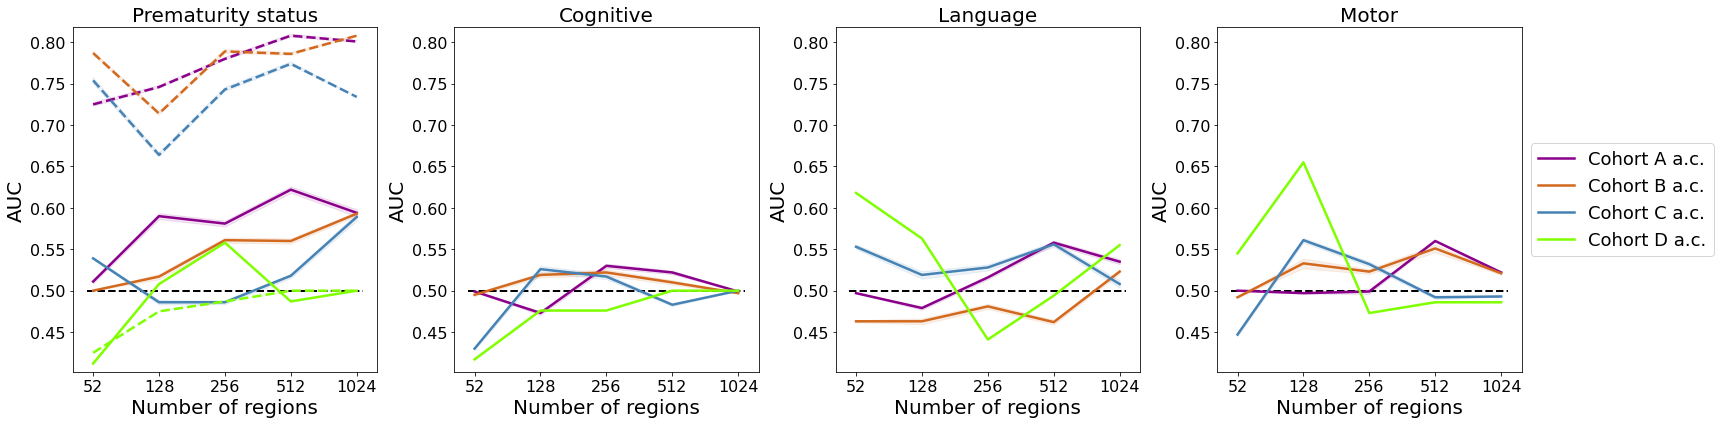

In [24]:
df = pd.read_csv('../../Results/predictions/AUC_categorical.csv')
#results = results[results.Task == 'prematurity']
segms = ['Segmentation 52', 'Random 128', 'Random 256', 'Random 512', 'Random 1024']

fix, axs = plt.subplots(1,4, figsize=(24,6), sharey=False)
axs = axs.ravel()
colors = ['darkmagenta', 'chocolate', 'steelblue', 'chartreuse', 'lightcoral']

auc = [col for col in df.columns if 'AUC' in col]
for ax, outcome in enumerate(['prematurity', 'Cognitive', 'Language', 'Motor']):
    
    results = df[df.Task == outcome]
    if outcome == 'prematurity':
        outcome = 'Prematurity status'
    for cohort, c , cohort_label in zip(['A', 'C', 'D', 'E'], colors, ['A', 'B', 'C', 'D']):
        col = 'Cohort_{}_AUC'.format(cohort) 
        x =range(len(segms))
    
        ## after correction 
        y = [results[results['Input '] == segm +' corrected'][col].values for segm in segms ]
        y1 =[results[results['Input '] == segm+' corrected']['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
        y2 = [results[results['Input '] == segm+' corrected']['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
        axs[ax].plot(x,y, label = 'Cohort {} a.c.'.format(cohort_label), color=c, linestyle='-', linewidth=2.5)
        axs[ax].fill_between(x, y1, y2, color=c, alpha=0.1)
        
        ## pre-correction
        if outcome == 'Prematurity status':
            y = [results[results['Input '] == segm][col].values for segm in segms ]
            y1 =[results[results['Input '] == segm]['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
            y2 = [results[results['Input '] == segm]['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
            axs[ax].plot(x,y, label = 'Cohort {}'.format(cohort_label), color=c, linestyle='--', linewidth=2.5)
            axs[ax].fill_between(x, y1, y2, color=c,  linestyle='--', alpha=0.1)
    

        
        axs[ax].set_ylim(np.min(df[auc].values)-0.01, np.max(df[auc].values)+0.01)

    axs[ax].set_title(outcome, fontsize =20)
    axs[ax].hlines(0.5,-.1,4.1, linestyles='dashed', colors='black', linewidth=2)
    axs[ax].set_ylabel('AUC', fontsize=20)
    axs[ax].set_xlabel('Number of regions', fontsize=20)
    axs[ax].set_xticks(ticks=x)
    axs[ax].set_xticklabels([segm.split(' ')[1] for segm in segms], size=16)
    
    axs[ax].tick_params(axis='both', which='major', labelsize=16)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.tight_layout()
plt.savefig('../../Results/figures/predictive_results_cohorts_LOOCV_cat.png', dpi=500, facecolor='white', transparent=False)
plt.show()
    
    

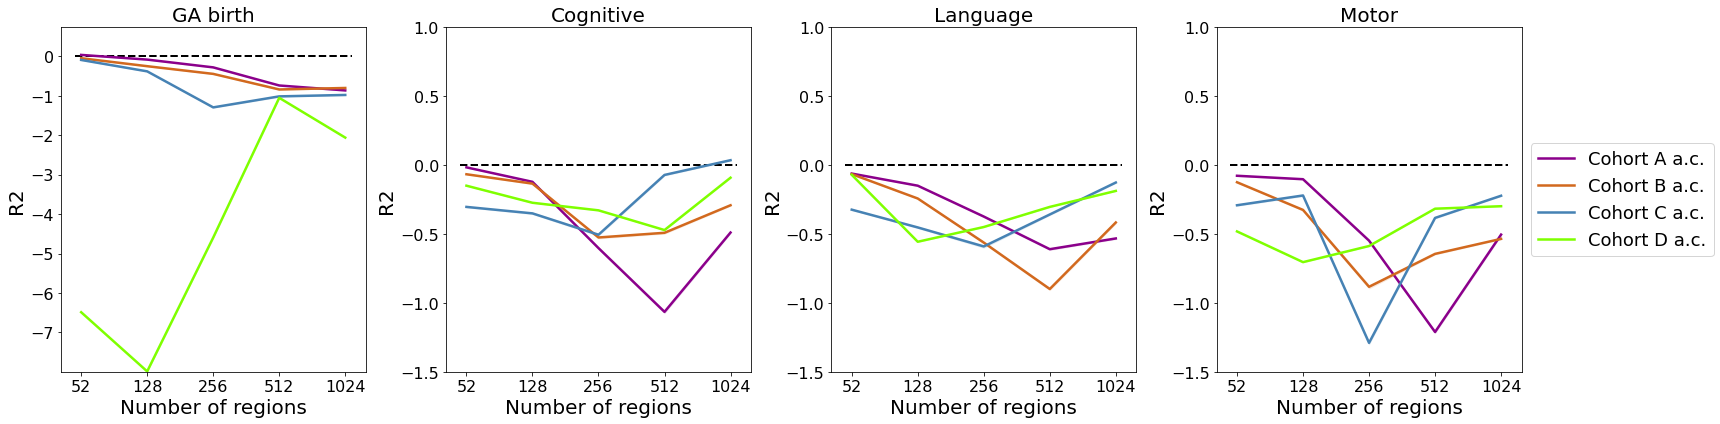

In [3]:
df = pd.read_csv('../../Results/predictions/R2_continous.csv')
#results = results[results.Task == 'prematurity']
segms = ['Segmentation 52', 'Random 128', 'Random 256', 'Random 512', 'Random 1024']

fix, axs = plt.subplots(1,4, figsize=(24,6), sharey=False)
axs = axs.ravel()
colors = ['darkmagenta', 'chocolate', 'steelblue', 'chartreuse', 'lightcoral']

auc = [col for col in df.columns if 'R2' in col]
for ax, outcome in enumerate(['GA birth', 'Cognitive', 'Language', 'Motor']):
    
    results = df[df.Task == outcome]
    if outcome == 'prematurity':
        outcome = 'Prematurity'
    #for cohort, c in zip(['A', 'B', 'C', 'D', 'E'], colors):
    for cohort, c , cohort_label in zip(['A', 'C', 'D', 'E'], colors, ['A', 'B', 'C', 'D']):
        
        col = 'Cohort_{}_R2'.format(cohort) 
        x =range(len(segms))
    
        ## pre-correction
        #y = [results[results['Input '] == segm][col].values for segm in segms ]
        #y1 =[results[results['Input '] == segm]['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
        #y2 = [results[results['Input '] == segm]['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
        #axs[ax].plot(x,y, label = 'Cohort {}'.format(cohort), color=c)
        #axs[ax].fill_between(x, y1, y2, color=c, alpha=0.4)
    
        ## after correction 
        y = [results[results['Input '] == segm +' corrected'][col].values for segm in segms ]
        y1 =[results[results['Input '] == segm+' corrected']['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
        y2 = [results[results['Input '] == segm+' corrected']['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
        axs[ax].plot(x,y, label = 'Cohort {} a.c.'.format(cohort_label), color=c, linestyle='-', linewidth=2.5) #, alpha=0.6, linewidth=2.5)
        axs[ax].fill_between(x, y1, y2, color=c, alpha=0.1)
        
        if outcome == 'GA birth':
            axs[ax].set_ylim(np.min(df[auc].values)-0.01, np.max(df[auc].values)+0.01)
        else: 
            axs[ax].set_ylim(-1.5, 1)
            
    axs[ax].set_title(outcome, fontsize=20)
    axs[ax].hlines(0,-.1,4.1, linestyles='dashed', colors='black', linewidth=2)
    axs[ax].set_ylabel('R2', fontsize=20)
    axs[ax].set_xlabel('Number of regions', fontsize=20)
    axs[ax].set_xticks(ticks=x)
    axs[ax].set_xticklabels([segm.split(' ')[1] for segm in segms])
    axs[ax].tick_params(axis='both', which='major', labelsize=16)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.tight_layout()
plt.savefig('../../Results/figures/predictive_results_cohorts_LOOCV.png', dpi=500, facecolor='white', transparent=False)
plt.show()
    

In [68]:
results.keys()

Index(['Task', 'Input ', 'Cohort_A_AUC', 'Cohort_A_min', 'Cohort_A_max',
       'Cohort_B_AUC', 'Cohort_B_min', 'Cohort_B_max', 'Cohort_C_AUC',
       'Cohort_C_min', 'Cohort_C_max', 'Cohort_D_AUC', 'Cohort_D_min',
       'Cohort_D_max', 'Cohort_E_AUC', 'Cohort_E_min', 'Cohort_E_max'],
      dtype='object')

## IMD 

In [52]:
results = pd.read_csv('../../Results/predictions/review_validation_categortical_IMD.csv', index_col=0)

In [55]:


def get_message(results, outcome, inputs, metric):
    
    try: 
        mean = np.nanmean(results[(results.outcome == outcome) & (results.inputs == inputs)][metric].values)
        std = np.nanstd(results[(results.outcome == outcome) & (results.inputs == inputs)][metric].values)
    
        # CI Depends on number of runs, in nested it is 10
        lim = 1.96 * (std/np.sqrt(5))
    except RuntimeWarning: 
        mean, std, lim = 0, 0, 0
    return '{:.3f} [{:.4f};{:.4f}]'.format(mean, mean-lim, mean+lim)

results = pd.read_csv('../../Results/predictions/review_validation_categortical_IMD.csv', index_col=0)
#results.loc[results.rho =='undefined', 'rho'] = np.nan
results['AUC'] = results['AUC'].astype(np.float32)
results['ACC'] = results['ACC'].astype(np.float32)
results['SPEC'] = results['SPEC'].astype(np.float32)
results['SENS'] = results['SENS'].astype(np.float32)

for col in ['y_true', 'y_pred']:
    results[col] = results[col].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

names = ['IMD']
in_n = ['IMD']
print('Outcome, Inputs,AUC [CI],ACC [CI],SPEC [CI],SENS [CI] ')
for outcome in np.unique(results.outcome.values):
    for name, inputs in zip(names,in_n ): # np.unique(results.inputs.values):
        
        print('{}, {},{},{},{},{}'.format(
                    outcome, name,
                   get_message(results=results, outcome=outcome, inputs=inputs, metric='AUC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='ACC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='SPEC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='SENS'),
                ))

Outcome, Inputs,AUC [CI],ACC [CI],SPEC [CI],SENS [CI] 
Cognitive_cat, IMD,0.500 [0.5000;0.5000],0.500 [0.5000;0.5000],1.000 [1.0000;1.0000],0.000 [0.0000;0.0000]
Language_cat, IMD,0.500 [0.5000;0.5000],0.500 [0.5000;0.5000],1.000 [1.0000;1.0000],0.000 [0.0000;0.0000]
Motor_cat, IMD,0.500 [0.5000;0.5000],0.500 [0.5000;0.5000],1.000 [1.0000;1.0000],0.000 [0.0000;0.0000]
group_cat, IMD,0.932 [0.8728;0.9905],0.932 [0.8728;0.9905],1.000 [1.0000;1.0000],0.863 [0.7456;0.9811]


In [61]:
df = pd.read_csv('../for_risk_and_env_factors.csv', index_col=0)


df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'

df['group_cat'] = 0
df.loc[df['GA_birth'] < 37, 'group_cat'] = 1

scores = ['Cognitive','Language','Motor']
for score in scores: 
    df[score+'_cat'] = 0
    df.loc[df[score] <= 85, score+'_cat'] = 1
    
with open(r"../../DerivedData/cohorts_subjects_list.pickle", "rb") as input_file:
    cohorts = pickle.load(input_file)
    
df = df[df.subject_id.isin(cohorts['A'])].copy()

In [64]:
pg.corr(df.group_cat, df.IMD)

,n,r,CI95%,p-val,BF10,power
pearson,295,-0.116818,"[-0.23, -0.0]",0.044989,0.538,0.519299


### Categorical nested - new minAD

In [8]:
def get_message(results, outcome, inputs, metric):
    
    try: 
        mean = np.nanmean(results[(results.outcome == outcome) & (results.inputs == inputs)][metric].values)
        std = np.nanstd(results[(results.outcome == outcome) & (results.inputs == inputs)][metric].values)
    
        # CI Depends on number of runs, in nested it is 10
        lim = 1.96 * (std/np.sqrt(10))
    except RuntimeWarning: 
        mean, std, lim = 0, 0, 0
    return '{:.3f} [{:.4f};{:.4f}]'.format(mean, mean-lim, mean+lim)

In [13]:
results = pd.read_csv('../../Results/predictions/new_inputFA_nested_validation_categorical.csv', index_col=0)
#results.loc[results.rho =='undefined', 'rho'] = np.nan
results['AUC'] = results['AUC'].astype(np.float32)
results['ACC'] = results['ACC'].astype(np.float32)
results['SPEC'] = results['SPEC'].astype(np.float32)
results['SENS'] = results['SENS'].astype(np.float32)

for col in ['y_true', 'y_pred']:
    results[col] = results[col].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

names = ['ROIs (52) a.c.', 'Random (128) a.c', 'Random (256) a.c', 'Random (512) a.c', 'Random (1024) a.c']
in_n = ['ROIs age corrected', '128', '256', '512', '1024']
print('Outcome, Inputs,AUC [CI],ACC [CI],SPEC [CI],SENS [CI] ')
for outcome in np.unique(results.outcome.values):
    for name, inputs in zip(names,in_n ): # np.unique(results.inputs.values):
        
        print('{}, {},{},{},{},{}'.format(
                    outcome, name,
                   get_message(results=results, outcome=outcome, inputs=inputs, metric='AUC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='ACC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='SPEC'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='SENS'),
                ))

Outcome, Inputs,AUC [CI],ACC [CI],SPEC [CI],SENS [CI] 
Cognitive Score_cat, ROIs (52) a.c.,0.474 [0.4340;0.5138],0.474 [0.4340;0.5138],0.881 [0.8203;0.9419],0.067 [-0.0160;0.1493]
Cognitive Score_cat, Random (128) a.c,0.475 [0.4594;0.4899],0.475 [0.4594;0.4899],0.916 [0.8858;0.9462],0.033 [-0.0080;0.0747]
Cognitive Score_cat, Random (256) a.c,0.478 [0.4657;0.4900],0.478 [0.4657;0.4900],0.956 [0.9314;0.9801],0.000 [0.0000;0.0000]
Cognitive Score_cat, Random (512) a.c,0.498 [0.4944;0.5006],0.498 [0.4944;0.5006],0.995 [0.9888;1.0012],0.000 [0.0000;0.0000]
Cognitive Score_cat, Random (1024) a.c,0.493 [0.4836;0.5018],0.493 [0.4836;0.5018],0.985 [0.9672;1.0035],0.000 [0.0000;0.0000]
Language Score_cat, ROIs (52) a.c.,0.496 [0.4906;0.5010],0.496 [0.4906;0.5010],0.945 [0.8778;1.0131],0.046 [-0.0111;0.1034]
Language Score_cat, Random (128) a.c,0.460 [0.4261;0.4930],0.460 [0.4261;0.4930],0.887 [0.7969;0.9771],0.032 [0.0077;0.0564]
Language Score_cat, Random (256) a.c,0.479 [0.4525;0.5051],0.479 

### continuous

In [10]:
results = pd.read_csv('../../Results/predictions/new_inputFA_nested_validation_continuous.csv', index_col=0)
results.loc[results.rho =='undefined', 'rho'] = np.nan
results['rho'] = results['rho'].astype(np.float32)
results['r2'] = results['r2'].astype(np.float32)

for col in ['y_true', 'y_pred']:
    results[col] = results[col].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

names = ['ROIs (52) a.m.c.', 'Random (128) a.m.c', 'Random (256) a.m.c', 'Random (512) a.m.c', 'Random (1024) a.m.c']
in_n = ['ROIs age corrected', '128', '256', '512', '1024']
print('Outcome, Inputs, RHO [CI], MAE [CI], R2 [CI]')
for outcome in np.unique(results.outcome.values):
    for name, inputs in zip(names,in_n ): # np.unique(results.inputs.values):
        
        print('{}, {},{},{},{}'.format(
                    outcome, name,
                   get_message(results=results, outcome=outcome, inputs=inputs, metric='rho'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='mae'),
            get_message(results=results, outcome=outcome, inputs=inputs, metric='r2'),
                ))

Outcome, Inputs, RHO [CI], MAE [CI], R2 [CI]
Cognitive Score, ROIs (52) a.m.c.,-0.026 [-0.0981;0.0466],6.613 [6.2772;6.9489],-0.081 [-0.1129;-0.0485]
Cognitive Score, Random (128) a.m.c,0.002 [-0.0476;0.0508],6.517 [6.2554;6.7794],-0.076 [-0.0959;-0.0567]
Cognitive Score, Random (256) a.m.c,-0.044 [-0.1063;0.0177],6.739 [6.5065;6.9717],-0.141 [-0.2019;-0.0804]
Cognitive Score, Random (512) a.m.c,0.043 [-0.0379;0.1238],6.461 [6.1927;6.7291],-0.045 [-0.0630;-0.0265]
Cognitive Score, Random (1024) a.m.c,0.065 [-0.0103;0.1407],6.430 [6.1602;6.7006],-0.043 [-0.0605;-0.0246]
GA_birth, ROIs (52) a.m.c.,0.092 [-0.0038;0.1887],1.464 [1.3303;1.5976],-0.069 [-0.1599;0.0212]
GA_birth, Random (128) a.m.c,0.046 [-0.0915;0.1834],1.597 [1.4775;1.7163],-0.185 [-0.3618;-0.0073]
GA_birth, Random (256) a.m.c,-0.018 [-0.1568;0.1206],1.646 [1.4598;1.8321],-0.295 [-0.4497;-0.1411]
GA_birth, Random (512) a.m.c,-0.080 [-0.2404;0.0809],1.594 [1.4665;1.7211],-0.392 [-0.5363;-0.2480]
GA_birth, Random (1024) a.m.c

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


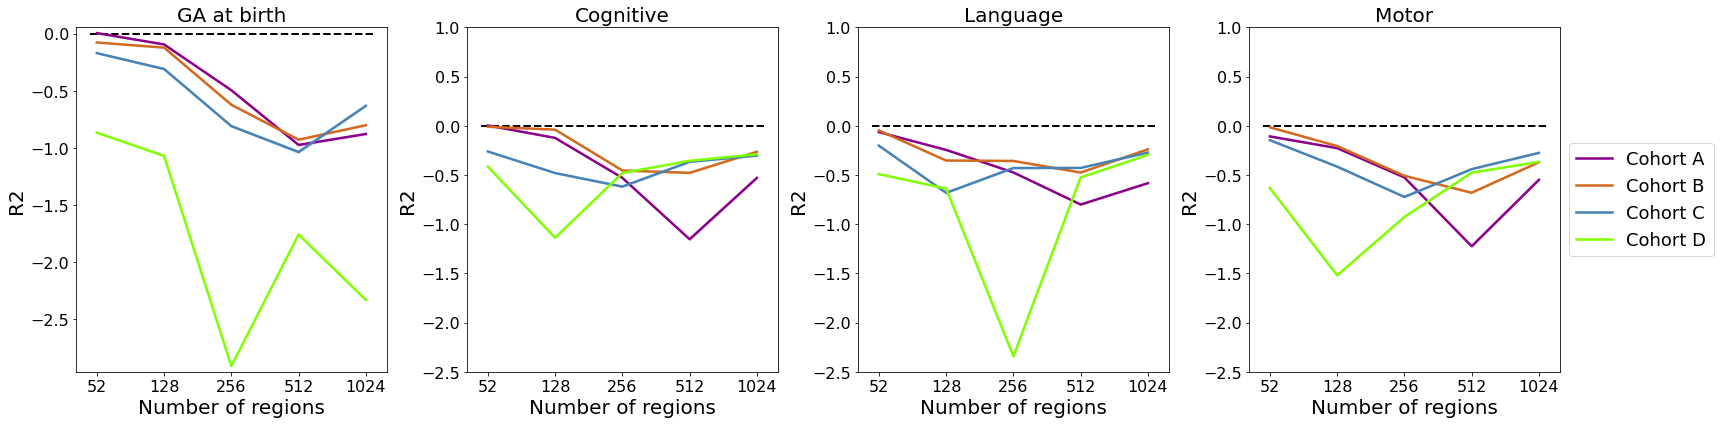

In [33]:
df = pd.read_csv('../../Results/predictions/new_inputsFA_R2_continous.csv')
#results = results[results.Task == 'prematurity']
segms = ['Segmentation 52', 'Random 128', 'Random 256', 'Random 512', 'Random 1024']

fix, axs = plt.subplots(1,4, figsize=(24,6), sharey=False)
axs = axs.ravel()
colors = ['darkmagenta', 'chocolate', 'steelblue', 'chartreuse', 'lightcoral']

auc = [col for col in df.columns if 'R2' in col]
for ax, outcome in enumerate(['GA birth', 'Cognitive', 'Language', 'Motor']):
    
    results = df[df.Task == outcome]
    if outcome == 'prematurity':
        outcome = 'Prematurity'
    elif outcome == 'GA birth':
        outcome = 'GA at birth'
    #for cohort, c in zip(['A', 'B', 'C', 'D', 'E'], colors):
    for cohort, c , cohort_label in zip(['A', 'B', 'C', 'D'], colors, ['A', 'B', 'C', 'D']):
        
        col = 'Cohort_{}_R2'.format(cohort) 
        x =range(len(segms))
    
        ## pre-correction
        #y = [results[results['Input '] == segm][col].values for segm in segms ]
        #y1 =[results[results['Input '] == segm]['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
        #y2 = [results[results['Input '] == segm]['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
        #axs[ax].plot(x,y, label = 'Cohort {}'.format(cohort), color=c)
        #axs[ax].fill_between(x, y1, y2, color=c, alpha=0.4)
    
        ## after correction 
        y = [results[results['Input '] == segm +' corrected'][col].values for segm in segms ]
        y1 =[results[results['Input '] == segm+' corrected']['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
        y2 = [results[results['Input '] == segm+' corrected']['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
        axs[ax].plot(x,y, label = 'Cohort {}'.format(cohort_label), color=c, linestyle='-', linewidth=2.5) #, alpha=0.6, linewidth=2.5)
        axs[ax].fill_between(x, y1, y2, color=c, alpha=0.1)
        
        if outcome == 'GA at birth':
            axs[ax].set_ylim(np.min(df[auc].values)-0.05, np.max(df[auc].values)+0.05)
        else: 
            axs[ax].set_ylim(-2.5, 1)
            
    axs[ax].set_title(outcome, fontsize=20)
    axs[ax].hlines(0,-.1,4.1, linestyles='dashed', colors='black', linewidth=2)
    axs[ax].set_ylabel('R2', fontsize=20)
    axs[ax].set_xlabel('Number of regions', fontsize=20)
    axs[ax].set_xticks(ticks=x)
    axs[ax].set_xticklabels([segm.split(' ')[1] for segm in segms])
    axs[ax].tick_params(axis='both', which='major', labelsize=16)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.tight_layout()
plt.savefig('../../Results/sanity_check_minAD/sanpredictive_results_cohorts_LOOCV.png', dpi=500, facecolor='white', transparent=False)
plt.show()
    

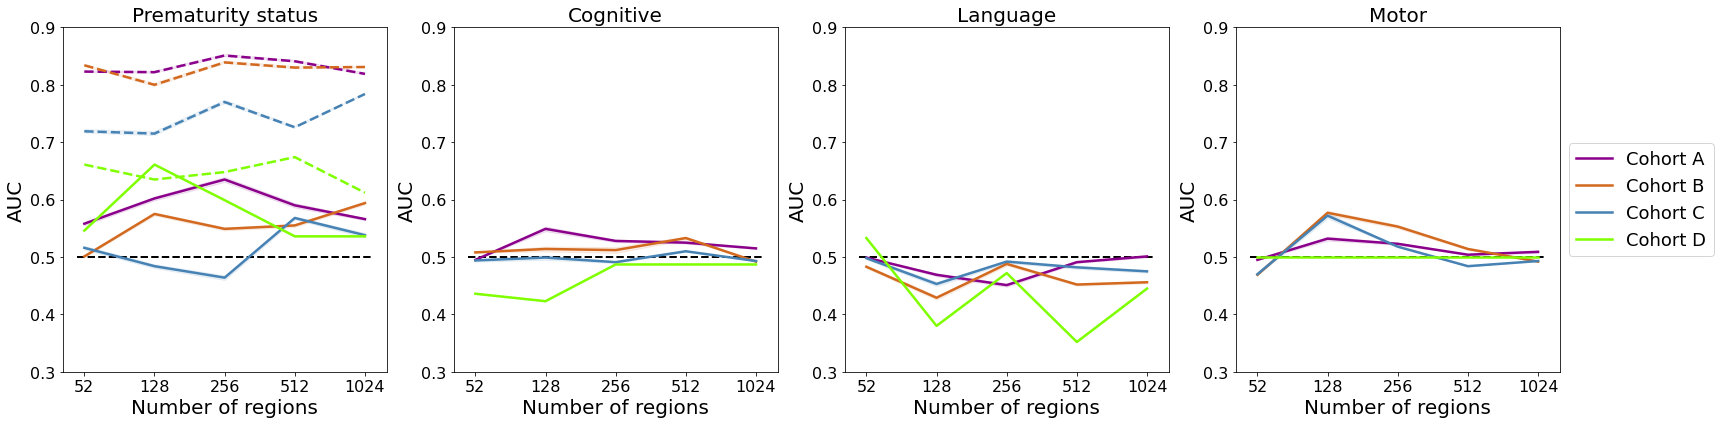

In [17]:
df = pd.read_csv('../../Results/predictions/new_inputsFA_AUC_categorical.csv')
#results = results[results.Task == 'prematurity']
segms = ['Segmentation 52', 'Random 128', 'Random 256', 'Random 512', 'Random 1024']

fix, axs = plt.subplots(1,4, figsize=(24,6), sharey=False)
axs = axs.ravel()
colors = ['darkmagenta', 'chocolate', 'steelblue', 'chartreuse', 'lightcoral']

auc = [col for col in df.columns if 'AUC' in col]
for ax, outcome in enumerate(['prematurity', 'Cognitive', 'Language', 'Motor']):
    
    results = df[df.Task == outcome]
    if outcome == 'prematurity':
        outcome = 'Prematurity status'
    for cohort, c , cohort_label in zip(['A', 'B', 'C', 'D'], colors, ['A', 'B', 'C', 'D']):
        col = 'Cohort_{}_AUC'.format(cohort) 
        x =range(len(segms))
    
        ## after correction 
        y = [results[results['Input '] == segm +' corrected'][col].values for segm in segms ]
        y1 =[results[results['Input '] == segm+' corrected']['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
        y2 = [results[results['Input '] == segm+' corrected']['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
        axs[ax].plot(x,y, label = 'Cohort {}'.format(cohort_label), color=c, linestyle='-', linewidth=2.5)
        axs[ax].fill_between(x, y1, y2, color=c, alpha=0.1)
        
        ## pre-correction
        if outcome == 'Prematurity status':
            y = [results[results['Input '] == segm][col].values for segm in segms ]
            y1 =[results[results['Input '] == segm]['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
            y2 = [results[results['Input '] == segm]['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
            axs[ax].plot(x,y, label = 'Cohort {}'.format(cohort_label), color=c, linestyle='--', linewidth=2.5)
            axs[ax].fill_between(x, y1, y2, color=c,  linestyle='--', alpha=0.1)
    

        
        axs[ax].set_ylim(0.3, 0.9)

    axs[ax].set_title(outcome, fontsize =20)
    axs[ax].hlines(0.5,-.1,4.1, linestyles='dashed', colors='black', linewidth=2)
    axs[ax].set_ylabel('AUC', fontsize=20)
    axs[ax].set_xlabel('Number of regions', fontsize=20)
    axs[ax].set_xticks(ticks=x)
    axs[ax].set_xticklabels([segm.split(' ')[1] for segm in segms], size=16)
    
    axs[ax].tick_params(axis='both', which='major', labelsize=16)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.tight_layout()
plt.savefig('../../Results/sanity_check_minAD/predictive_results_cohorts_LOOCV_cat.png', dpi=500, facecolor='white', transparent=False)
plt.show()

## showing results of the nested predictions in D 

In [4]:
results = pd.read_csv('../../Results/predictions/new_inputFA_nested_validation_continuous.csv', index_col=0)
results.loc[results.rho =='undefined', 'rho'] = np.nan
results['rho'] = results['rho'].astype(np.float32)
results['r2'] = results[
    'r2'].astype(np.float32)

for col in ['y_true', 'y_pred']:
    results[col] = results[col].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

In [25]:
norm

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
/volatile/miniconda3/envs/ohbm/lib/python3.7/sit

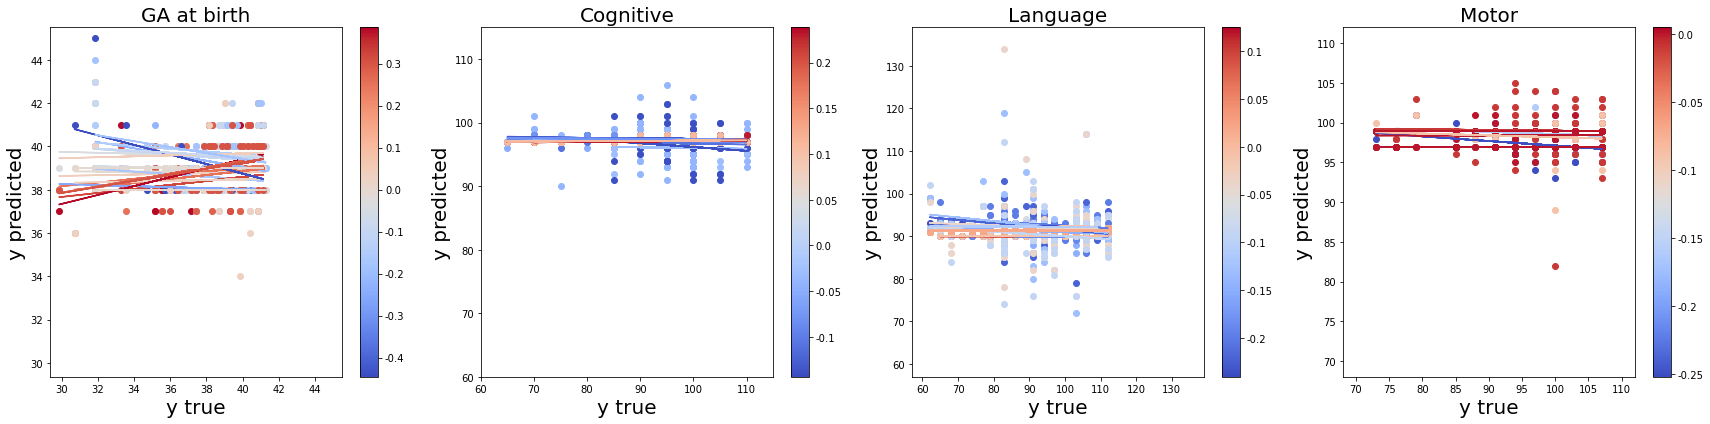

In [51]:
from matplotlib import cm
from matplotlib import colors

outcomes = ['GA_birth', 'Cognitive Score', 'Language Score', 'Motor Score']
names = ['GA at birth', 'Cognitive', 'Language', 'Motor']
fix, axs = plt.subplots(1,4, figsize=(24,6), sharey=False)

for i, outcome in enumerate(outcomes):
    df = results[results.outcome == outcome]
    min_ax = []
    max_ax = []
    
    rho= []
    for idx, row in df.iterrows():
        r = pg.corr(row.y_true, row.y_pred)
        rho.append(np.float64(r['r'][0]))
    rho = np.nan_to_num(rho, nan=0.0)
    
    #set colors
    sm = plt.cm.ScalarMappable(cmap=cm.coolwarm)
    sm.set_clim(vmin=np.min(rho)*100, vmax=np.max(rho)*100)
    #sm.set_clim(vmin=-50, vmax=50)
    norm = colors.Normalize(vmin=np.min(rho)*100, vmax=np.max(rho)*100)
    #norm = colors.Normalize(vmin=-50, vmax=500)
    f=0
    for idx, row in df.iterrows():
        
        
        axs[i].scatter(row.y_true, row.y_pred,color=sm.cmap(norm(int(rho[f]*100))))
        axs[i].set_xlabel('y true', fontsize=20)
        axs[i].set_ylabel('y predicted', fontsize=20)
        axs[i].set_title(names[i], fontsize=20)
        
        # regression line 
        m, b = np.polyfit(row.y_true, row.y_pred, deg=1)
        axs[i].plot(row.y_true, b + m*row.y_true, linestyle='-', c=sm.cmap(norm(int(rho[f]*100))))
        
        min_ax.append(np.min([np.min(row.y_true),np.min(row.y_pred)]))
        max_ax.append(np.max([np.max(row.y_true),np.max(row.y_pred)]))
        f=f+1
        
    if outcome == 'GA_birth':
        axs[i].set_ylim(np.min(min_ax)-0.5, np.max(max_ax)+0.5)
        axs[i].set_xlim(np.min(min_ax)-0.5, np.max(max_ax)+0.5)
    else: 
        axs[i].set_ylim(np.min(min_ax)-5, np.max(max_ax)+5)
        axs[i].set_xlim(np.min(min_ax)-5, np.max(max_ax)+5)

    #axs[i].legend()
    
    cbar = plt.colorbar(sm, ax=axs[i])
    cbar.ax.set_yticklabels([i * 0.01 for i in cbar.get_ticks()])
    #axs[i].colorbar(sm)
plt.tight_layout()
plt.savefig('../../Results/sanity_check_minAD/nested_10runs.png', dpi=500, facecolor='white', transparent=False)
plt.show()

### for reviewers

In [7]:
df

,Task,Input,Cohort_A_AUC,Cohort_A_min,Cohort_A_max
0,prematurity,GA birth,1.000,1.0000,1.0000
1,prematurity,Segmentation (52),0.541,0.5243,0.5577
2,prematurity,Random 128,0.490,0.4745,0.5055
3,prematurity,Random 256,0.462,0.4552,0.4688
4,prematurity,Random 512,0.434,0.4241,0.4439
5,prematurity,Random 1024,0.503,0.4937,0.5123


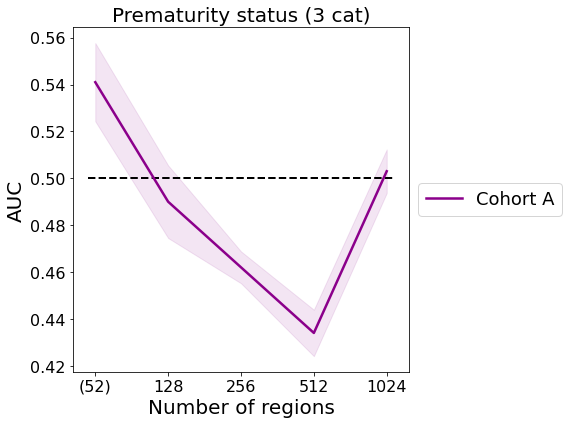

In [13]:
df = pd.read_csv('../../Results/predictions/AUC_categorical_3groups.csv')
#results = results[results.Task == 'prematurity']
segms = ['Segmentation (52)', 'Random 128', 'Random 256', 'Random 512', 'Random 1024']

fix, axs = plt.subplots(1,1, figsize=(8,6), sharey=True)

colors = ['darkmagenta']

auc = [col for col in df.columns if 'AUC' in col]
for ax, outcome in enumerate(['prematurity']):
    
    results = df[df.Task == outcome]
    if outcome == 'prematurity':
        outcome = 'Prematurity status (3 cat)'
    for cohort, c , cohort_label in zip(['A'], colors, ['A']):
        col = 'Cohort_{}_AUC'.format(cohort) 
        x =range(len(segms))
    
        ## after correction 
        y = [results[results['Input'] == segm ][col].values for segm in segms ]
        y1 =[results[results['Input'] == segm]['Cohort_{}_min'.format(cohort)].values[0] for segm in segms ]
        y2 = [results[results['Input'] == segm]['Cohort_{}_max'.format(cohort)].values[0] for segm in segms ]
        axs.plot(x,y, label = 'Cohort {}'.format(cohort_label), color=c, linestyle='-', linewidth=2.5)
        axs.fill_between(x, y1, y2, color=c, alpha=0.1)
        
        #axs[ax].set_ylim(np.min(df[auc].values)-0.01, np.max(df[auc].values)+0.01)

    axs.set_title(outcome, fontsize =20)
    axs.hlines(0.5,-.1,4.1, linestyles='dashed', colors='black', linewidth=2)
    axs.set_ylabel('AUC', fontsize=20)
    axs.set_xlabel('Number of regions', fontsize=20)
    axs.set_xticks(ticks=x)
    axs.set_xticklabels([segm.split(' ')[1] for segm in segms], size=16)
    
    axs.tick_params(axis='both', which='major', labelsize=16)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
plt.tight_layout()
#plt.savefig('../../Results/sanity_check_minAD/predictive_results_cohorts_LOOCV_cat.png', dpi=500, facecolor='white', transparent=False)
plt.show()
    